In [90]:
import numpy as np 
from scipy import stats 
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.colors as colors
import sys
from iminuit import Minuit
import pandas as pd
from scipy.special import comb

from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline


In [6]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [247]:
def setMplParam(classNum, start_with=0):
    COLOUR = ['#1E90FF', '#FFBF00', '#FF6347', '#00A86B', '#5A4FCF','#D473D4', '#00CCFF']
    LINE = ['--', '-', '-.', '-', ':', '--','-']
    MARKER = ['o', '*', '^', 's', '.', 'p', 'o']
    
    COLOUR = COLOUR[start_with:] + COLOUR[:start_with]
    LINE = LINE[start_with:] + LINE[:start_with]
    MARKER = MARKER[start_with:] + MARKER[:start_with]

    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                        plt.cycler(linestyle=LINE_EFF) +
                                        plt.cycler(marker=MARKER_EFF))
    plt.rcParams['lines.markersize'] = 5  # Example size
    plt.rcParams['lines.linewidth'] = 2  # Example width

    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20
    
    plt.rcParams['legend.fontsize'] = 12

    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    mpl.rcParams['axes.linewidth'] = 2

    mpl.rcParams['xtick.major.size'] = 7
    mpl.rcParams['xtick.major.width'] = 3
    mpl.rcParams['xtick.minor.size'] = 2
    mpl.rcParams['xtick.minor.width'] = 2

    mpl.rcParams['ytick.major.size'] = 7
    mpl.rcParams['ytick.major.width'] = 3
    mpl.rcParams['ytick.minor.size'] = 2
    mpl.rcParams['ytick.minor.width'] = 2

setMplParam(6)

In [297]:
def trapezoidal(y_values, h):
    n = len(y_values)
    if n < 2:
        # Not enough points to apply the rule
        return 0
    else:
        sum_y = np.sum(y_values[1:-1])  # Sum of y values excluding the first and last
        return (h/2) * (y_values[0] + 2 * sum_y + y_values[-1])

In [298]:
def normaliser(df):
    x_values = np.arange(len(df))
    y_values = df['V'].values
    h = 1e-5  # Assuming equidistant points for simplicity
    return trapezoidal(y_values, h)


NameError: name 'df' is not defined

In [296]:
df_log = pd.read_csv('dust.dat',header=None, delim_whitespace=True)
df_myst = pd.read_csv('cubic.dat',header=None, delim_whitespace=True)
df_osc = pd.read_csv('osc.dat',header=None, delim_whitespace=True)
dfs = [df_log, df_myst, df_osc]
for data in dfs:
    data.columns = ['D', 'V']
    data['V_norm'] = data['V'] / normaliser(data)

In [289]:
def linearSpline(df, smoothness):
    x = df['D']
    y = df['V_norm']
    linear_spline = interp1d(x, y, kind='linear')
    
    x_new = np.arange(x.min(), x.max(), 0.01)
    y_new = linear_spline(x_new)
    return x_new, y_new


In [290]:
def cubicSpline(df, smoothness):
    x = df['D']
    y = df['V_norm']
    cubic_spline = CubicSpline(x, y)
    
    x_new = np.arange(x.min(), x.max(), 0.01)
    y_new = cubic_spline(x_new)
    return x_new, y_new


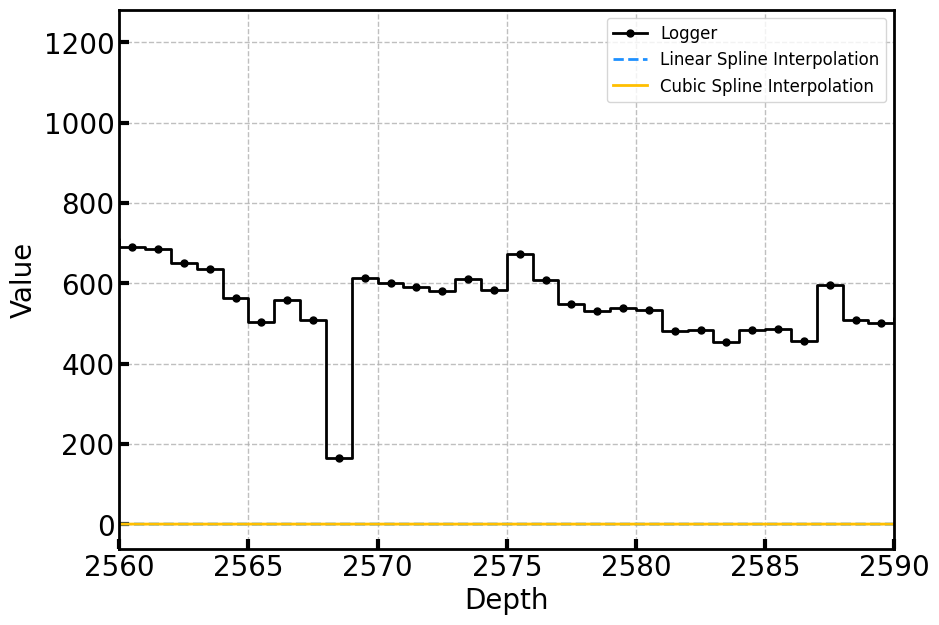

In [291]:
def interpolater(df, smoothness):
    x_l, y_l = linearSpline(df, smoothness)
    x_c, y_c = cubicSpline(df, smoothness)
    
    # Plotting the original data and the interpolated curve
    fig, ax = plt.subplots(figsize = (10, 7))
    setMplParam(6, start_with=6)
    ax.step(df['D'], df['V'], color = 'k', where = 'mid', linestyle = '-', label = 'Logger')  # Original data points
    ax.plot(x_l, y_l, label='Linear Spline Interpolation', marker = '')  # Interpolated curve
    ax.plot(x_c, y_c, label='Cubic Spline Interpolation', marker = '')  # Interpolated curve
    ax.set_xlabel('Depth')
    ax.set_ylabel('Value')
    ax.legend()
    ax.set_xlim((2560, 2590))

interpolater(df_log, df_log.shape[0]/10)

In [299]:
def trapezoidal_bound(y_values, h, bound):
    n = len(y_values)
    if n < 2:
        # Not enough points to apply the rule
        return 0
    else:
        sum_y = np.sum(y_values[1:-1])  # Sum of y values excluding the first and last
        return (h/2) * (y_values[0] + 2 * sum_y + y_values[-1])

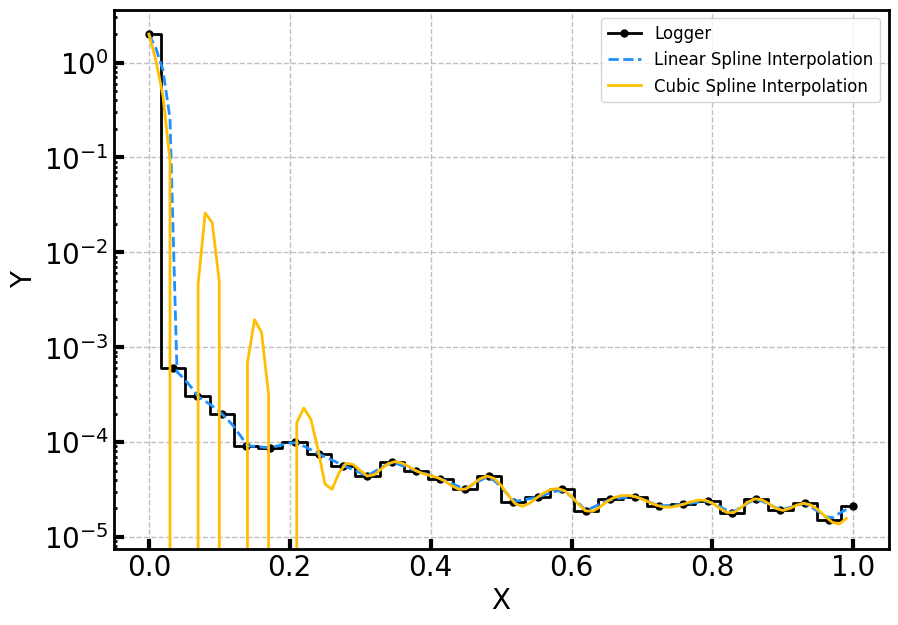

In [294]:
def interpolater_Myst(df, smoothness):
    x_l, y_l = linearSpline(df, smoothness)
    x_c, y_c = cubicSpline(df, smoothness)
    
    # Plotting the original data and the interpolated curve
    fig, ax = plt.subplots(figsize = (10, 7))
    setMplParam(6, start_with=6)
    ax.step(df['D'], df['V_norm'], color = 'k', where = 'mid', linestyle = '-', label = 'Logger')  # Original data points
    ax.plot(x_l, y_l, label='Linear Spline Interpolation', marker = '')  # Interpolated curve
    ax.plot(x_c, y_c, label='Cubic Spline Interpolation', marker = '')  # Interpolated curve
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    plt.semilogy()

interpolater_Myst(df_myst, df_myst.shape[0])